In [2]:
%load_ext autoreload
%autoreload 2
import torch
import copy
import os

import torch
import tqdm
import torchvision

from typing import Literal

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training.bounded_models import IntervalBoundedModel

import uci_datasets  # python -m pip install git+https://github.com/treforevans/uci_datasets.git
torch.manual_seed(0)

In [3]:
batchsize = 1000000
data = uci_datasets.Dataset("houseelectric")
print(data)
x_train, y_train, x_test, y_test = data.get_split(split=0)

# Normalise the features and labels
x_train_mu, x_train_std = x_train.mean(axis=0), x_train.std(axis=0)
x_train = (x_train - x_train_mu) / x_train_std
x_test = (x_test - x_train_mu) / x_train_std
y_train_min, y_train_range = y_train.min(axis=0), y_train.max(axis=0) - y_train.min(axis=0)
y_train = (y_train - y_train_min) / y_train_range
y_test = (y_test - y_train_min) / y_train_range

# Form datasets and dataloaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
test_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

houseelectric dataset, N=2049280, d=11


In [4]:
import torch.nn.functional as F
from abstract_gradient_training.bounded_models import BoundedModel
def noisy_test_mse(
    model: torch.nn.Sequential | BoundedModel,
    batch: torch.Tensor,
    labels: torch.Tensor,
    *,
    noise_level: float | torch.Tensor = 0.0,
    noise_type: str = "laplace",
) -> float:
    """
    Given a pytorch (or bounded) model, calculate the prediction accuracy on a batch of the test set when adding the
    specified noise to the predictions.
    NOTE: For now, this function only supports binary classification via the noise + threshold dp mechanism. This
          should be extended to support multi-class problems via the noisy-argmax mechanism in the future.

    Args:
        model (torch.nn.Sequential | BoundedModel): The model to evaluate.
        batch (torch.Tensor): Input batch of data (shape [batchsize, ...]).
        labels (torch.Tensor): Targets for the input batch (shape [batchsize, ]).
        noise_level (float | torch.Tensor, optional): Noise level for privacy-preserving predictions using the laplace
            mechanism. Can either be a float or a torch.Tensor of shape (batchsize, ).
        noise_type (str, optional): Type of noise to add to the predictions, one of ["laplace", "cauchy"].

    Returns:
        float: The noisy accuracy of the model on the test set.
    """
    # get the test batch and send it to the correct device
    if isinstance(model, BoundedModel):
        device = torch.device(model.device) if model.device != -1 else torch.device("cpu")
    else:
        device = torch.device(next(model.parameters()).device)
    batch = batch.to(device)

    # validate the labels
    if labels.dim() > 1:
        labels = labels.squeeze()
    labels = labels.to(device).type(torch.int64)
    assert labels.dim() == 1, "Labels must be of shape (batchsize, )"

    # validate the noise parameters and set up the distribution
    assert noise_type in ["laplace", "cauchy"], f"Noise type must be one of ['laplace', 'cauchy'], got {noise_type}"
    noise_level += 1e-7  # can't set distributions scale to zero
    noise_level = torch.tensor(noise_level) if isinstance(noise_level, float) else noise_level
    noise_level = noise_level.to(device).type(batch.dtype)  # type: ignore
    noise_level = noise_level.expand(labels.size())
    if noise_type == "laplace":
        noise_distribution = torch.distributions.Laplace(0, noise_level)
    else:
        noise_distribution = torch.distributions.Cauchy(0, noise_level)

    # nominal, lower and upper bounds for the forward pass
    y_n = model.forward(batch).squeeze()

    # transform 2-logit models to a single output
    if y_n.shape[-1] == 2:
        y_n = y_n[:, 1] - y_n[:, 0]
    if y_n.dim() > 1:
        raise NotImplementedError("Noisy accuracy is not supported for multi-class classification.")

    # apply noise + threshold dp mechanisim
    noise = noise_distribution.sample().to(y_n.device).squeeze()
    assert noise.shape == y_n.shape
    y_n = y_n + noise
    accuracy = F.mse_loss(y_n, labels.squeeze()).item()
    return accuracy

In [5]:
import importlib
import privacy_utils_regression
importlib.reload(privacy_utils_regression)

for lr in [25, 50, 75, 100]:  
    for epochs in [10, 20, 30, 40, 50]:     
        print(f"Learning rate: {lr/100}, Num epochs: {epochs} --")
        privacy_bounded_models = {}
        k_private_values = [1, 2, 5, 10, 20, 50, 100] 
        for k in k_private_values:
            model = torch.nn.Sequential(torch.nn.Linear(11, 64), torch.nn.ReLU(), torch.nn.Linear(64, 1))
            bounded_model = IntervalBoundedModel(model, trainable=True)
            bounded_model.load_params(f"models/{lr}/{epochs}/uci_k{k}.model")
            privacy_bounded_models[k] = bounded_model
        # evaluate the fine-tuned model
        accuracy = agt.test_metrics.test_mse(bounded_model, *test_data.tensors)
        print(f"Fine-tuned model accuracy + certified bounds (all classes): {accuracy[0]:.2f} <= {accuracy[1]:.2f} <= {accuracy[2]:.2f}")

        epsilon = 1.0
        # make privacy-safe predictions using the smooth sensitivity bounds from AGT
        noise_level = privacy_utils_regression.get_calibrated_noise_level(
            test_data.tensors[0], privacy_bounded_models, min_bound=0, max_bound=1, epsilon=epsilon, noise_type="cauchy" 
        )

        accuracy = noisy_test_mse(
            bounded_model, *test_data.tensors, noise_level=noise_level, noise_type="cauchy"
        )
        print(accuracy / len(test_data))
        print(f"Accuracy using AGT smooth sensitivity bounds: {accuracy:.2f}")

        ave = 0
        num = 3000
        for i in range(num):
            ave += noisy_test_mse(
                bounded_model, *test_data.tensors, noise_level=noise_level, noise_type="cauchy"
            )
        print(f"Average MSE is {ave / (num * len(test_data))}")

        ave = 0
        num = 3000
        for i in range(num):
            ave += noisy_test_mse(
                bounded_model, *test_data.tensors, noise_level=6, noise_type="cauchy"
            )
        print(f"Average MSE global sensitivity is {ave / (num * len(test_data))}")

Learning rate: 0.25, Num epochs: 10 --
Fine-tuned model accuracy + certified bounds (all classes): 0.26 <= 0.02 <= 0.00
0.0776137638509013
Accuracy using AGT smooth sensitivity bounds: 15905.23
Average MSE is 2.0632512212856944
Average MSE global sensitivity is 623.6792108553065
Learning rate: 0.25, Num epochs: 20 --
Fine-tuned model accuracy + certified bounds (all classes): 102.08 <= 0.01 <= 0.00
1.8099975967168958
Accuracy using AGT smooth sensitivity bounds: 370919.19
Average MSE is 19.71707035761239
Average MSE global sensitivity is 665.5949503280319
Learning rate: 0.25, Num epochs: 30 --
Fine-tuned model accuracy + certified bounds (all classes): 11142.46 <= 0.01 <= 0.00
43.64259642410993
Accuracy using AGT smooth sensitivity bounds: 8943590.00
Average MSE is 127.85322660898483
Average MSE global sensitivity is 658.8617530322642
Learning rate: 0.25, Num epochs: 40 --
Fine-tuned model accuracy + certified bounds (all classes): 99663.71 <= 0.01 <= 0.00
5.267356705769831
Accuracy us

KeyboardInterrupt: 

In [11]:
lr = 25
epochs = 10

privacy_bounded_models = {}
k_private_values = [1, 2, 5, 10, 20, 50, 100] 
for k in k_private_values:
    model = torch.nn.Sequential(torch.nn.Linear(11, 64), torch.nn.ReLU(), torch.nn.Linear(64, 1))
    bounded_model = IntervalBoundedModel(model, trainable=True)
    bounded_model.load_params(f"models/{lr}/{epochs}/uci_k{k}.model")
    privacy_bounded_models[k] = bounded_model
# evaluate the fine-tuned model
accuracy = agt.test_metrics.test_mse(bounded_model, *test_data.tensors)
print(f"Fine-tuned model accuracy + certified bounds (all classes): {accuracy[0]:.2f} <= {accuracy[1]:.2f} <= {accuracy[2]:.2f}")

epsilon = 1.0
# make privacy-safe predictions using the smooth sensitivity bounds from AGT
noise_level = privacy_utils_regression.get_calibrated_noise_level(
    test_data.tensors[0], privacy_bounded_models, min_bound=0, max_bound=1, epsilon=epsilon, noise_type="cauchy" 
)

accuracy = noisy_test_mse(
    bounded_model, *test_data.tensors, noise_level=noise_level, noise_type="cauchy"
)
print(accuracy / len(test_data))
print(f"Accuracy using AGT smooth sensitivity bounds: {accuracy:.2f}")

ave = 0
num = 100
for i in range(num):
    ave += noisy_test_mse(
        bounded_model, *test_data.tensors, noise_level=noise_level, noise_type="cauchy"
    )
print(f"Average MSE is {ave / (num * len(test_data))}")

ave = 0
num = 100
for i in range(num):
    ave += noisy_test_mse(
        bounded_model, *test_data.tensors, noise_level=6, noise_type="cauchy"
    )
print(f"Average MSE global sensitivity is {ave / (num * len(test_data))}")

Fine-tuned model accuracy + certified bounds (all classes): 0.26 <= 0.02 <= 0.00
0.001085214135350472
Accuracy using AGT smooth sensitivity bounds: 222.39
Average MSE is 0.527378100107641
Average MSE global sensitivity is 949.0822663783133


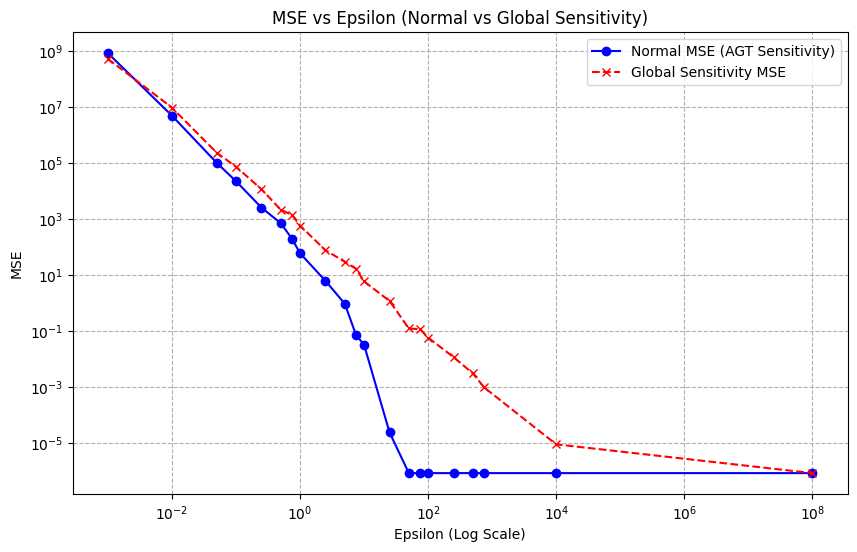

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the specific epsilon values
epsilon_values = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 750, 10000, 100000000]

# Store results for both normal MSE and global sensitivity-based MSE
normal_mse_values = []
global_sensitivity_mse_values = []

# Loop over epsilon values and calculate the MSE for each
for epsilon in epsilon_values:
    # Calculate the noise level using AGT smooth sensitivity bounds
    noise_level = privacy_utils_regression.get_calibrated_noise_level(
        test_data.tensors[0], privacy_bounded_models, min_bound=0, max_bound=1, epsilon=epsilon, noise_type="cauchy"
    )
    
    ave = 0
    num = 100
    for i in range(num):
        ave += noisy_test_mse(
            bounded_model, *test_data.tensors, noise_level=noise_level, noise_type="cauchy"
        )
    normal_mse = ave / (num * len(test_data))
    # print(f"Average MSE is {ave / (num * len(test_data))}")
    
    # Store normal MSE
    normal_mse_values.append(normal_mse)
    

    ave = 0
    num = 100
    for i in range(num):
        ave += noisy_test_mse(
            bounded_model, *test_data.tensors, noise_level=6/epsilon, noise_type="cauchy"
        )
    
    global_mse = ave / (num * len(test_data))
    # Store global sensitivity MSE
    global_sensitivity_mse_values.append(global_mse)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both MSE curves
plt.plot(epsilon_values, normal_mse_values, label="Normal MSE (AGT Sensitivity)", color="blue", marker='o')
plt.plot(epsilon_values, global_sensitivity_mse_values, label="Global Sensitivity MSE", color="red", linestyle="--", marker='x')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Epsilon (Log Scale)')
plt.ylabel('MSE')
plt.title('MSE vs Epsilon (Normal vs Global Sensitivity)')
plt.legend()

# Show the plot
plt.grid(True, which="both", ls="--")  # Add grid for both major and minor ticks
plt.show()
